# Pros of added details

author: laquitainesteeve@gmail.com

Execution time:

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM

prerequisites:
- 15 MB to store cell models
- sorted recordings with kilosort4  
    - Buccino [DONE]
    - Buccino clone [DONE]

Note:
- the original Buccino dataset has no metadata about the cells and we have no control on the parameters so we used MEAREC to re-simulate it, then we'll modify one parameter at a time.
- intermediate simulations are too heavy to be saved together - they should be reproducible with the seeds used.
- monitor disk storage with df -h

## Setup 

Activate mearec virtual environment

In [22]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os 
import MEArec as mr
import numpy as np
import spikeinterface.extractors as se 
import spikeinterface.sorters as sorters 
import spikeinterface.comparison as sc  
from matplotlib import pyplot as plt;
import spikeinterface as si
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms
import spikeinterface.qualitymetrics as sqm
import spikeinterface.core.template_tools as ttools
from numpy.linalg import norm as lalgnorm
import warnings
warnings.filterwarnings('ignore')

# SET PROJECT PATH

PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import firing_rate as fr
from src.nodes.analysis.failures import isolation

# parameters
DURATION_S = 600 # duration of recording period considered in seconds

# SET DATA PATHS

# original buccino simulation
RECORDING_BUCCINO_PATH = 'dataset/01_intermediate/preprocessing/recording_buccino/'
GROUND_TRUTH_BUCCINO_PATH = 'dataset/00_raw/ground_truth_buccino/'
WAVEFORM_GT_BUCCINO_PATH =  './temp/pros_of_details/waveformextractor_buccino/'

# setup simulation common template parameters
DATA_PATH = './temp/pros_of_details/'
CELLS_PATH = mr.get_default_cell_models_folder()
TEMPLATES_PATH = './temp/pros_of_details/templates.h5'

# setup synthetic simulation version 2 common parameters
RECORDING_CLONE_H5_PATH = './temp/pros_of_details/recordings.h5'
RECORDING_CLONE_PATH = 'dataset/00_raw/recording_buccino_clone/'
GROUND_TRUTH_CLONE_PATH = 'dataset/00_raw/ground_truth_buccino_clone/'
WAVEFORM_GT_CLONE_PATH =  './temp/pros_of_details/waveformextractor_buccino_clone/'

# setup synthetic synthetic version 2 parameters
RECORDING_S2_H5_PATH = './temp/pros_of_details/recordings_s2.h5'
RECORDING_S2_PATH = 'dataset/00_raw/recording_buccino_s2/'
GROUND_TRUTH_S2_PATH = 'dataset/00_raw/ground_truth_buccino_s2/'
WAVEFORM_GT_S2_PATH =  './temp/pros_of_details/waveformextractor_buccino_s2/'

# parallel processing parameters
N_JOBS = 20
CHUNKS = 50000

# npx_spont
RECORDING_NS_PATH = 'dataset/01_intermediate/preprocessing/recording_npx_spont/'
GROUND_TRUTH_NS_PATH = 'dataset/00_raw/ground_truth_npx_spont/'
WAVEFORM_GT_NS_PATH = 'dataset/01_intermediate/waveforms/ground_truth_npx_spont/'

# parallel processing parameters 
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.13 ms, sys: 18 µs, total: 1.15 ms
Wall time: 1.04 ms


In [13]:
# UTILS 

def _euclidean_distance(coord_1, coord_2):
    return np.sqrt(np.sum((coord_1 - coord_2) ** 2))


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def get_waveform_amplitudes_per_unit(We):
    return si.postprocessing.compute_spike_amplitudes(We, peak_sign="neg", outputs="by_unit")[0]


# SIMULATE SYNTHETIC RECORDING WITH MEAREC

def simulate_synthetic_recording_with_mearec(rec_prms: dict, layer:str, templates_path, recording_clone_h5_path, recording_clone_path, sorting_gt_clone_path, n_jobs, chunks):

    # generate simulated recording (takes 22 min)
    rec_gen = mr.gen_recordings(params=rec_prms, templates=templates_path)

    # save simulated recording
    mr.save_recording_generator(rec_gen, recording_clone_h5_path)

    # load recording h5 file
    RecordingClone = se.MEArecRecordingExtractor(recording_clone_h5_path) 
    RecordingClone.set_property("layers", np.array([layer]*384)) # add layer metadata

    # load ground truth
    SortingClone = se.MEArecSortingExtractor(recording_clone_h5_path)

    # save recording extractors
    RecordingClone.save(folder=recording_clone_path, n_jobs=n_jobs, 
                verbose=True, progress_bar=True, overwrite=True, 
                dtype="float32", chunk_size=chunks)
    
    # save sorting extractors
    SortingClone.save(folder=sorting_gt_clone_path, overwrite=True)

    # delete intermediate h5 file
    os.remove(recording_clone_h5_path)
    return RecordingClone, SortingClone, rec_gen


def report_simulation_parameters(rec_gen):
    """
    Reports simulation parameters, checks for bursting, and displays example cell metadata.

    Args:
        rec_gen (RecordingGenerator): The recording generator object.
    """
    # report parameters
    display('Simulation parameters:', rec_gen.info)

    # check bursting
    bursting = []
    for ix in range(250):
        bursting.append(rec_gen.spiketrains[1].annotations['bursting'])
    print('Bursting:', any(bursting))

    # example of a cell metadata
    CELL_IDX = 0
    print('\nExample cell type:', rec_gen.template_celltypes[CELL_IDX])
    display('Its spiking metadata:', rec_gen.spiketrains[CELL_IDX].annotations)
    print('Its spike times:', rec_gen.spiketrains[CELL_IDX].times)


# QUALITY METRICS FOR A SINGLE UNIT

def get_spatial_spread(
    We, unit_id: int, max_chids: dict, channel_ids, channel_coord
):
    """measure unit's spatial spread

    Args:
        unit_id (int): _description_
        max_chids (dict): _description_
        Recording (_type_): _description_
        channel_ids (_type_): _description_
        channel_coord (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get waveforms
    wv, _ = We.get_waveforms(unit_id=unit_id, with_index=True)    

    # get the site ids (sparse)
    c_ids = We.sparsity.unit_id_to_channel_ids[unit_id]

    # get the nearest site
    max_chid = max_chids[unit_id]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    
    # get the average spike on each site
    mean_spikes = wv.mean(axis=0)
    max_spike = mean_spikes[:, max_chid_ix]
    
    # measure the average spike's similarity 
    # of each site to the average spike
    # of the nearest site to the unit
    # (ratio between 0 and 1)
    n_sites = mean_spikes.shape[1]
    cosim_weights = []
    for s_i in range(n_sites):
        cosim_weights.append(
            np.dot(max_spike, mean_spikes[:, s_i])
            / (lalgnorm(max_spike) * lalgnorm(mean_spikes[:, s_i]))
        )
    cosim_weights = np.array(cosim_weights)

    # threshold the similarity metric to be positive
    # we only look at similarity (not inverse similarity (<0))
    cosim_weights[cosim_weights < 0] = 0

    # measure the distance of the site to the nearest site
    # to the unit
    channel_coord = channel_coord[np.isin(channel_ids, c_ids), :]
    try:
        max_chids_coord = channel_coord[max_chid_ix, :]
    except:
        from ipdb import set_trace; set_trace()
        
    dist = []
    for ix, _ in enumerate(c_ids):
        dist.append(_euclidean_distance(max_chids_coord, channel_coord[ix]))
    dist = np.array(dist)

    # return spatial spread
    return {
        "spatial_spread": np.dot(cosim_weights, dist),
        "channel_distance": dist,
        "weights": cosim_weights,
    }


# QUALITY METRICS / SPIKE FEATURES FOR ALL UNITS

def get_firing_rates(sorting, duration_s):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - sorting: spikeinterface SortingExtractor
        The sorting extractor containing spike trains.
    - duration_s: the total duration
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    unit_ids = sorting.get_unit_ids()
    firing_rates = [
        len(sorting.get_unit_spike_train(unit_id)) / duration_s
        for unit_id in unit_ids
    ]
    return firing_rates


def get_firing_ranges(waveform_extractor):

    firing_range = sqm.compute_firing_ranges(waveform_extractor=waveform_extractor)
    return np.array(list(firing_range.values()))


def get_waveform_amplitude_medians(waveform_extractor):

    amplitude_medians = sqm.compute_amplitude_medians(waveform_extractor=waveform_extractor)
    return np.array(list(amplitude_medians.values()))


def get_waveform_snr(waveform_extractor):
    snrs = sqm.compute_snrs(waveform_extractor=waveform_extractor)
    return np.array(list(snrs.values()))


def get_spatial_spread_all_units(
    recording_path: str, study_path: str, ms_before=3, ms_after=3, peak_sign="neg"
):
    """get all units' spatial extent metrics

    Args:
        recording_path (str): Path of the Recording Extractor
        study_path (str): _description_
        ms_before (float): _description_
        ms_after (float): _description_

    Returns:
        (dict): spatial spread of each unit
        - key: true unit id
        - value: spatial spread
    
    Prerequisites:
        - have extracted ground truth waveforms
    """
    # takes 1:30 min
    We = si.WaveformExtractor.load_from_folder(study_path)
    
    # get sites' distance to the max site
    # get 3D coordinates
    Rec = si.load_extractor(recording_path)
    channel_coord = Rec.get_probe().contact_positions
    channel_ids = Rec.get_channel_ids()

    # get channels where spike amplitude is maximal
    max_chids = ttools.get_template_extremum_channel(
        We, peak_sign=peak_sign)

    # takes 1:30 min (1310 units)
    spatial_spread = dict()
    for _, unit in enumerate(We.unit_ids):
        spatial_spread[unit] = get_spatial_spread(
            We, unit, max_chids, channel_ids, channel_coord
        )["spatial_spread"]
    return np.array(list(spatial_spread.values()))


def get_mad_ratios(WeOriginal):
    """get mad ratio per unit. Values close to 1 indicate a good isolation of the unit.
    i.e., the mean absolute deviation of the spike amplitude is similar to the mean absolute deviation 
    of the noise amplitude.

    Args:
        WeOriginal (WaveformExtractor): _description_

    Returns:
        np.array: mad ratio per unit
    """
    # pre-compute negative spike amplitudes
    amplitudes_by_unit = get_waveform_amplitudes_per_unit(WeOriginal)

    # get nearest channels
    max_chids = ttools.get_template_extremum_channel(WeOriginal, peak_sign="both")

    # compute mad ratio per unit
    mad_ratio = []
    for unit in WeOriginal.unit_ids:
        noise_amp = get_best_site_mad_noise(WeOriginal, max_chids, unit)
        mad_ratio.append(get_mad_ratio(amplitudes_by_unit[unit], noise_amp))
    return np.array(mad_ratio)


# PLOTS 

def plot_firing_rate_distribution(ax, firing_rates, bins=20, title:str='simulation_name', ylim=(0,60), xlim=(0,25)):
    """
    Plots the firing rate distribution of units in a sorting extractor.

    Parameters:
    - firing rates: firing rates
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_rates, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing rate (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)    
    ax.set_title(title)


def plot_firing_ranges_distribution(ax, firing_ranges, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(firing_ranges, bins=bins, edgecolor='k')
    ax.set_xlabel("Firing range (Hz)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_amplitude_median_distribution(ax, amplitudes, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - amplitudes: waveform amplitudes
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(amplitudes, bins=bins, edgecolor='k')
    ax.set_xlabel("Amplitudes (uV)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_waveform_snr_distribution(ax, snrs, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - snrs: snrs
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(snrs, bins=bins, edgecolor='k')
    ax.set_xlabel("SNR")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_spatial_spread_distribution(ax, mad_ratio, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratio: mad_ratio
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratio, bins=bins, edgecolor='k')
    ax.set_xlabel("Spatial spread (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)


def plot_mad_ratio_distribution(ax, mad_ratios, bins=20, title:str='simulation_name', ylim=(0,50), xlim=(0,800)):
    """
    Parameters:
    - mad_ratios: waveform mean-absolute deviation ratio between spike amplitude and background noise
    - bins: int, optional
        Number of bins for the histogram (default is 20).
    """
    ax.hist(mad_ratios, bins=bins, edgecolor='k')
    ax.set_xlabel("MAD ratios (a.u)")
    ax.set_ylabel("Unit count")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title)

# Quality of unit isolation (single-unit yield)

def process_each_experiment(sorted1, sorted2):
    """
    Process sorting data by retrieving, filtering, and standardizing unit data.
    Keep units in L1 to L6 (in cortex)

    Returns:
        dict: A dictionary containing processed DataFrames for sorting data.
    """
    # get unit data
    sorting_data = {
        f"s_original": fr.get_sorted_unit_meta(sorted1),
        f"s_clone": fr.get_sorted_unit_meta(sorted2),
    }

    # standardize layer 2/3
    for key in sorting_data:
        sorting_data[key]["layer"][
            (sorting_data[key]["layer"] == "L2") | (sorting_data[key]["layer"] == "L3") | (sorting_data[key]["layer"] == "L2_3")
        ] = "L2/3"

    # keep units in cortex
    for key in sorting_data:
        sorting_data[key] = sorting_data[key][
            np.isin(sorting_data[key]["layer"], ["L1", "L2", "L2/3", "L4", "L5", "L6"])
        ]
    return sorting_data

## Simulate intermediate synthetic datasets

In [ ]:
# # setup common cell template, probe, seed parameters
# tpl_prms = mr.get_default_templates_params()
# tpl_prms['probe'] = 'Neuropixels-384'           # neuropixel probe
# tpl_prms['n'] = 200                             # number of templates per cell model
# tpl_prms['seed'] = 0                            # setup reproducibility

# # generate and save the templates (10 min for 200 templates per cell, 15MB)
# tpl_gen = mr.gen_templates(cell_models_folder=cells_path, params=tpl_prms)
# mr.save_template_generator(tpl_gen, templates_path)
# print("Cells path:", cells_path)

### Dataset 1

In [ ]:
# setup parameters
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['n_exc'] = 200
rec_prms['spiketrains']['n_inh'] = 50
rec_prms['spiketrains']['duration'] = 600
rec_prms['seeds']['spiketrains'] = 0
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

# simulate synthetic recording with MEArec
RecordingClone, SortingClone, RecGen = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_CLONE_H5_PATH, RECORDING_CLONE_PATH, SORTING_GT_CLONE_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGen)

### Dataset 2

In [ ]:
# setup parameters
rec_prms = mr.get_default_recordings_params()
rec_prms['spiketrains']['n_exc'] = 200  # number of excitatory cells
rec_prms['spiketrains']['n_inh'] = 50   # number of inhibitory cells
rec_prms['spiketrains']['duration'] = 600
rec_prms['seeds']['spiketrains'] = 0
rec_prms['seeds']['templates'] = 1
rec_prms['seeds']['noise'] = 2
rec_prms['seeds']['convolution'] = 3

# modified parameters
rec_prms['spiketrains']['f_exc'] = 5    # average firing rate of excitatory cells in Hz
rec_prms['spiketrains']['f_inh'] = 15   # average firing rate of inhibitory cells in Hz

# simulate synthetic recording with MEArec (takes 23 min)
RecordingS2, SortingS2, RecGenS2 = simulate_synthetic_recording_with_mearec(rec_prms, 'L5', TEMPLATES_PATH, RECORDING_S2_H5_PATH, RECORDING_S2_PATH, GROUND_TRUTH_S2_PATH, N_JOBS, CHUNKS)

# report parameters
report_simulation_parameters(RecGenS2)

Loading templates...
Done loading templates...
Spiketrains seed:  0
dtype float32
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 2.221845865249634
Creating time jittering
Elapsed jitter time: 4.321073770523071
Smoothing templates
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  1367.8804434880149
write_binary_recording with n_jobs = 20 and chunk_size = 50000


write_binary_recording:   0%|          | 0/384 [00:00<?, ?it/s]

'Simulation parameters:'

{'spiketrains': {'n_exc': 200,
  'n_inh': 50,
  'f_exc': 5,
  'f_inh': 15,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0.5,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 600},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': 0, 'templates': 1, 'convolution': 3, 'noise': 2},
 'templates': {'min_dist': 25,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3],
  'smooth_percent': 0.5,
  'smooth_strength': 1,
  'cut_out': [2, 5],
  'overlapping': array([[  0, 201],
         [  0, 211],
         [  4, 154],
         [  5,  16],
         [  9, 134],
         [ 10, 246],
         [ 21,  88],
         [ 21, 195],
         [ 24, 124],
         [ 26, 107],
         [ 27, 148],
         [ 27, 197],
         [ 28,  29],

Bursting: False

Example cell type: L5_TTPC1_cADpyr232_1


'Its spiking metadata:'

{'fr': array(6.76405235) * Hz,
 'cell_type': 'E',
 'snr': 6.02367057800293,
 'bintype': 'E',
 'mtype': 'L5_TTPC1_cADpyr232_1',
 'soma_position': array([   63.4268411 ,   -31.49461335, -1384.20106309]),
 'bursting': False,
 'exp_decay': None,
 'max_spikes_per_burst': None,
 'max_burst_duration': None}

Its spike times: [2.95467164e-02 2.59253024e-01 2.67905811e-01 ... 5.99354775e+02
 5.99790655e+02 5.99904599e+02] s


## Load/compute data

In [23]:
%%time

# load orginal Buccino (already bandpass filtered 300 - 6000 Hz)
RecordingBuccino = si.load_extractor(RECORDING_BUCCINO_PATH)
SortingGtBuccino = si.load_extractor(GROUND_TRUTH_BUCCINO_PATH)

# load Buccino clone (already bandpass filtered 300 - 6000 Hz)
RecordingClone = si.load_extractor(RECORDING_CLONE_PATH)
SortingGtClone = si.load_extractor(GROUND_TRUTH_CLONE_PATH)

# load Buccino S2 (already bandpass filtered 300 - 6000 Hz)
RecordingS2 = si.load_extractor(RECORDING_S2_PATH)
SortingGtS2 = si.load_extractor(GROUND_TRUTH_S2_PATH)

# load npx_spont (preprocessed high-pass filtered >300 Hz)
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
SortingGtNS = si.load_extractor(GROUND_TRUTH_NS_PATH)
SortingGtNS = remove_excess_spikes(SortingGtNS, RecordingNS)
SortingGtNS = SortingGtNS.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_S)

# extract waveforms (typically takes 20 secs)
WeGtOriginal = extract_waveforms(RecordingBuccino, SortingGtBuccino, WAVEFORM_GT_BUCCINO_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtClone = extract_waveforms(RecordingClone, SortingGtClone, WAVEFORM_GT_CLONE_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtS2 = extract_waveforms(RecordingS2, SortingGtS2, WAVEFORM_GT_S2_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

WeGtNS = extract_waveforms(RecordingNS, SortingGtNS, WAVEFORM_GT_NS_PATH,
    sparse=True, ms_before=3.0, ms_after=3.0, max_spikes_per_unit=500, unit_batch_size=200,
    overwrite=True, seed=0, **job_kwargs)

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/600 [00:00<?, ?it/s]

CPU times: user 16.8 s, sys: 54.5 s, total: 1min 11s
Wall time: 1min 47s


## Compute/plot quality features

We can match:

- nb of cells
- ...

In [ ]:
%%time

# setup  plot 
fig, axes = plt.subplots(6,4, figsize=(5,6))

# CELL SPIKING FEATURES ---------------


# firing rates
firing_rates = get_firing_rates(SortingGtBuccino, duration_s=600) # original Buccino
plot_firing_rate_distribution(axes[0,0], firing_rates, title='Original Buccino', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtClone, duration_s=600) # our Buccino clone
plot_firing_rate_distribution(axes[0,1], firing_rates, title='Buccino clone', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtS2, duration_s=600) # our S2
plot_firing_rate_distribution(axes[0,2], firing_rates, title='Buccino 2', ylim=(0,60), xlim=(0,25))

firing_rates = get_firing_rates(SortingGtNS, duration_s=600) # npx_spont
plot_firing_rate_distribution(axes[0,3], firing_rates, title='NS', ylim=(0,1000), xlim=(0,25))


# firing range
firing_ranges = get_firing_ranges(WeGtOriginal)
plot_firing_ranges_distribution(axes[1,0], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtClone)
plot_firing_ranges_distribution(axes[1,1], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtS2)
plot_firing_ranges_distribution(axes[1,2], firing_ranges, title='', ylim=(0,60), xlim=(0,8))

firing_ranges = get_firing_ranges(WeGtNS)
plot_firing_ranges_distribution(axes[1,3], firing_ranges, title='', ylim=(0,1000), xlim=(0,8))


# CELL WAVEFORM FEATURES ---------------

# waveform amplitudes
amplitudes_o = get_waveform_amplitude_medians(WeGtOriginal)
plot_waveform_amplitude_median_distribution(axes[2,0], amplitudes_o, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtClone)
plot_waveform_amplitude_median_distribution(axes[2,1], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_c = get_waveform_amplitude_medians(WeGtS2)
plot_waveform_amplitude_median_distribution(axes[2,2], amplitudes_c, title='', ylim=(0,65), xlim=(0,600))

amplitudes_ns = get_waveform_amplitude_medians(WeGtNS)
plot_waveform_amplitude_median_distribution(axes[2,3], amplitudes_ns, title='', ylim=(0,1000), xlim=(0,600))


# signal-to-noise ratio (SNR)
snrs = get_waveform_snr(WeGtOriginal)
plot_waveform_snr_distribution(axes[3,0], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtClone)
plot_waveform_snr_distribution(axes[3,1], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtS2)
plot_waveform_snr_distribution(axes[3,2], snrs, title='', ylim=(0,65), xlim=(0,70))

snrs = get_waveform_snr(WeGtNS)
plot_waveform_snr_distribution(axes[3,3], snrs[np.isfinite(snrs)], title='', ylim=(0,1000), xlim=(0,70))


# spatial spread
spreads = get_spatial_spread_all_units(RECORDING_BUCCINO_PATH, WAVEFORM_GT_BUCCINO_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,0], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_CLONE_PATH, WAVEFORM_GT_CLONE_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,1], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_S2_PATH, WAVEFORM_GT_S2_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,2], spreads, title='', ylim=(0,40), xlim=(0,1200))

spreads = get_spatial_spread_all_units(RECORDING_NS_PATH, WAVEFORM_GT_NS_PATH, ms_before=3, ms_after=3, peak_sign="neg")
plot_spatial_spread_distribution(axes[4,3], spreads, title='', ylim=(0,300), xlim=(0,1200))


# mad ratio
mad_ratios = get_mad_ratios(WeGtOriginal)
plot_mad_ratio_distribution(axes[5,0], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtClone)
plot_mad_ratio_distribution(axes[5,1], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtS2)
plot_mad_ratio_distribution(axes[5,2], mad_ratios, title='', ylim=(0,40), xlim=(0,15))

mad_ratios = get_mad_ratios(WeGtNS)
plot_mad_ratio_distribution(axes[5,3], mad_ratios, title='', ylim=(0,800), xlim=(0,15))


# CELL POSITIONS -----------------------

# distances to electrode

fig.tight_layout(pad=0.1)

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/600 [00:00<?, ?it/s]

## Yields

In [7]:
SORTED_ks4_paths = {
    "s_original": 'dataset/01_intermediate/sorting/buccino/SortingKS4',
    "s_clone": './temp/npx_synth_clone/SortingKS4_10m_RTX5090',
}

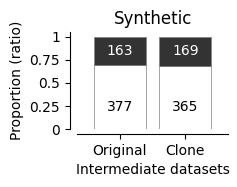

In [8]:
# parameters
exp = 'Synthetic'

# compute data
plot_data = process_each_experiment(SORTED_ks4_paths['s_original'], SORTED_ks4_paths['s_clone'])

# setup
FIGSIZE = (2.5, 2)
SHIFT = 0.3
exp_names = ('Original', 'Clone')
number_pos = {'exp1_x':-0.3 + SHIFT, 'exp1_y_su': 0.2, 'exp1_y_mu': 0.8, 
              'exp2_x': 0.7 + SHIFT, 'exp2_y_su': 0.2, 'exp2_y_mu': 0.8}
legend_cfg = {"frameon": False, "handletextpad": 0.1}

# plot (white: single-unit; black: multi-units)
_, ax = plt.subplots(1,1,figsize=FIGSIZE)
isolation.plot_unit_isolation_pros_of_added_detailed(ax, plot_data['s_original'], plot_data['s_clone'], legend_cfg, number_pos, exp_names)

# legend
ax.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])
ax.set_title(exp)
plt.tight_layout()

In [ ]:
# # clean up default temporary data - you will need to reinstall mearec afterward with pip intall mearec
# import shutil
# shutil.rmtree(CELLS_PATH, ignore_errors=True)